In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory
import tensorflow as tf
import seaborn as sns
import matplotlib.pyplot as plt
import os

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [ ]:
!kaggle datasets download -d tanlikesmath/diabetic-retinopathy-resized

100% 7.24G/7.25G [01:11<00:00, 89.1MB/s]
100% 7.25G/7.25G [01:11<00:00, 109MB/s] 


In [ ]:
import zipfile
zip=zipfile.ZipFile('/content/diabetic-retinopathy-resized.zip','r')
zip.extractall('/content')
zip.close()

In [ ]:
import pandas as pd
data=pd.read_csv('trainLabels_cropped.csv')
data.shape

(35108, 4)

In [ ]:
data=data.drop(columns=['Unnamed: 0.1','Unnamed: 0'],axis=1)

In [ ]:
data.head()

,image,level
0,10_left,0
1,10_right,0
2,13_left,0
3,13_right,0
4,15_left,1


In [ ]:
def extention_train_data(x):
    return x+".jpeg"

In [ ]:
data['image'] = data['image'].apply(extention_train_data)

In [ ]:
data['level']= data['level'].apply(str)

In [ ]:
data['level'].dtypes

dtype('O')

In [ ]:
data['image'].head()

0     10_left.jpeg
1    10_right.jpeg
2     13_left.jpeg
3    13_right.jpeg
4     15_left.jpeg
Name: image, dtype: object

In [ ]:
from sklearn.model_selection import train_test_split
X = data['image'].head(1500)
y = data['level'].head(1500)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0, shuffle=True)

train_df = pd.DataFrame({'image': X_train, 'level': y_train}).reset_index(drop=True)
test_df = pd.DataFrame({'image': X_test, 'level': y_test}).reset_index(drop=True)

In [ ]:
len(X),len(y)

(1500, 1500)

In [ ]:
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1 / 255.0,
                                                               rotation_range = 10,
                                                               zoom_range = 0.30,
                                                               shear_range = 0.30,
                                                               fill_mode = "nearest"
                                                               )
test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1 / 255.0)

In [ ]:
train_generator = train_datagen.flow_from_dataframe(dataframe = train_df,
                                                    directory = '/content/resized_train_cropped/resized_train_cropped',
                                                    x_col = 'image',
                                                    y_col = 'level',
                                                    target_size=(224, 224),
                                                    color_mode='rgb',
                                                    class_mode='categorical',
                                                    batch_size=16)
test_generator = test_datagen.flow_from_dataframe(dataframe = test_df,
                                                    directory = '/content/resized_train_cropped/resized_train_cropped',
                                                    x_col = 'image',
                                                    y_col = 'level',
                                                    target_size=(224, 224),
                                                    color_mode='rgb',
                                                    class_mode='categorical',
                                                    batch_size=16)

Found 1125 validated image filenames belonging to 5 classes.
Found 375 validated image filenames belonging to 5 classes.


In [ ]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense,Dropout,InputLayer,Conv2D,MaxPooling2D,Flatten
from tensorflow.keras.applications.efficientnet import EfficientNetB3
from sklearn.metrics import accuracy_score,mean_squared_error
model = Sequential()
model.add(EfficientNetB3(include_top=False,input_shape=(224,224,3) ,pooling='avg', weights="imagenet"))
reg=tf.keras.regularizers.L2(l2=0.01)
model.add(Dense(5, activation='softmax'))
model.layers[0].trainable = False

In [ ]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
history=model.fit(train_generator,validation_data = test_generator,
                    steps_per_epoch = train_generator.n//train_generator.batch_size,
                    validation_steps = test_generator.n//test_generator.batch_size,epochs=5)

Epoch 1/5
70/70 [==============================] - 208s 3s/step - loss: 0.9086 - accuracy: 0.7394 - val_loss: 0.8947 - val_accuracy: 0.7147
Epoch 2/5
70/70 [==============================] - 229s 3s/step - loss: 0.8519 - accuracy: 0.7520 - val_loss: 0.8962 - val_accuracy: 0.7174
Epoch 3/5
70/70 [==============================] - 232s 3s/step - loss: 0.8482 - accuracy: 0.7520 - val_loss: 0.8964 - val_accuracy: 0.7092
Epoch 4/5
70/70 [==============================] - 190s 3s/step - loss: 0.8582 - accuracy: 0.7493 - val_loss: 0.9234 - val_accuracy: 0.7092
Epoch 5/5
70/70 [==============================] - 194s 3s/step - loss: 0.8567 - accuracy: 0.7520 - val_loss: 0.9197 - val_accuracy: 0.7174


In [ ]:
score = model.evaluate(test_generator)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

24/24 [==============================] - 47s 2s/step - loss: 0.9305 - accuracy: 0.7147
Test loss: 0.9304745197296143
Test accuracy: 0.7146666646003723


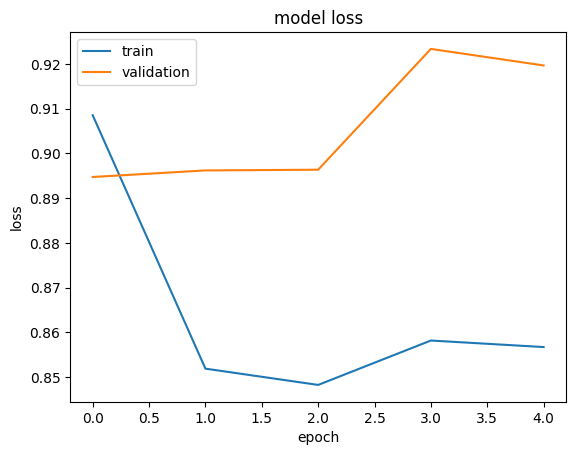

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()